In [1]:
from glob import glob
from pprint import pprint

import io
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import torch

%matplotlib inline

In [2]:
class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else: return super().find_class(module, name)


model_list = []
threshold_list = []
train_accuracy_list = []
val_accuracy_list = []
data = []
for model_path in glob('../data/results/20news/*'):
    model = model_path.split('/')[-1]
    if 'mask' in model:
        continue
    for file_path in glob(model_path + '/train/*'):
        threshold = file_path.split('/')[-1].split('_')[-1].split('.pkl')[0]
        model_list.append(model)
        threshold_list.append(threshold)
        with open(file_path, 'rb') as file:
            contents = CPU_Unpickler(file).load()
            train_accuracy_list.append(contents['train_accuracy'])
            val_accuracy_list.append(contents['val_accuracy'])
        data.append([model, threshold, float(max(contents['train_accuracy'])), float(max(contents['val_accuracy']))])
            
results = pd.DataFrame(data, columns=['model', 'threshold', 'train_accuracy', 'val_accuracy'])

In [3]:
results.groupby('model').max()['val_accuracy']

model
bert-base-cased       0.694076
bert-base-uncased     0.717949
bert-large-cased      0.602122
bert-large-uncased    0.713528
Name: val_accuracy, dtype: float64

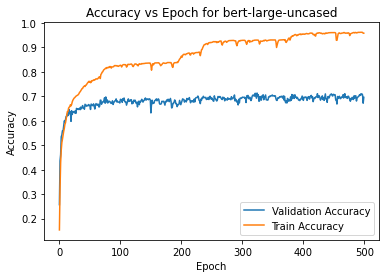

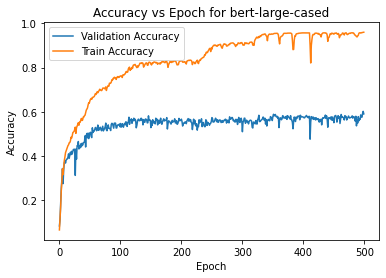

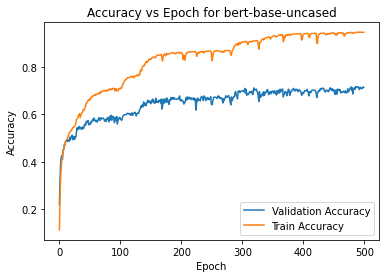

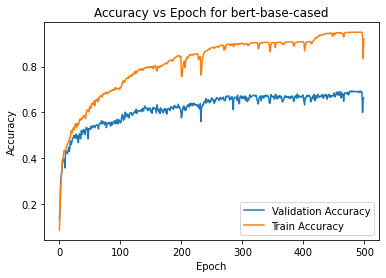

In [5]:
best_performing_indexes = [4, 11, 14, 23]
# fig, ax = plt.subplots(2, 2)
for index in best_performing_indexes:
    model = model_list[index]
    plt.plot(val_accuracy_list[index], label='Validation Accuracy')
    plt.plot(train_accuracy_list[index], label='Train Accuracy')
    plt.legend()
    plt.title('Accuracy vs Epoch for ' + model)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.show()